# Ball Challenge

Predicting the probability of impact given a three-channel timeseries of acceleration data (x-, y-, z-direction)
- Input: Three-channel acceleration data
    - Example data contains 1150 sample points per channel
- Output: Two-dimensional probability map containing the probability of impact for each cell in a grid
    - Assumption: 10x10 grid

In [1]:
import torch
import seaborn as sns

from ballchallenge.model import BallChallengeModel

In [2]:
signal_length = 1150
num_channels = 3

model = BallChallengeModel(
    total_bits=16,
    frac_bits=8,
    signal_length=signal_length,
    impact_grid_size=(10, 10),
)

random_inputs = torch.randn(num_channels, signal_length)
predicted_impact_map = model(random_inputs).detach()

<Axes: >

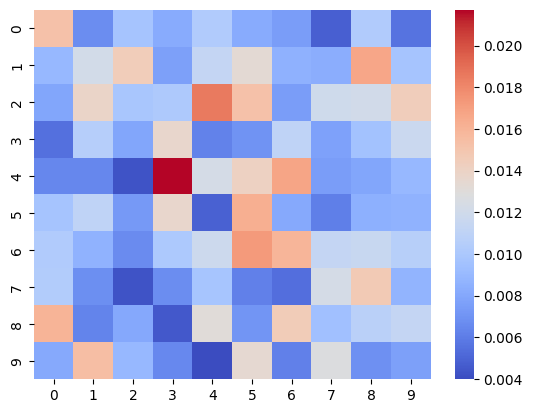

In [3]:
sns.heatmap(predicted_impact_map, cmap="coolwarm")